In [1]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("./Utils")
from utils import get_loaders, load_checkpoint
sys.path.append('./Models')
from U_net import UNET
import torchvision

In [2]:
path_train = "../Data/dataset_DRIVE/training/images/"
training_images = os.listdir(path_train)

In [3]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

In [4]:
train_images['21'].shape

(584, 565, 3)

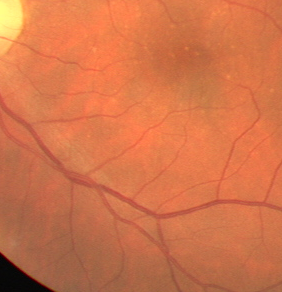

In [5]:
from torchvision.transforms import RandomCrop
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms.functional as TF
i, j, h, w = RandomCrop.get_params(
            PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
             output_size=(292, 282))
TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)

Text(0.5, 1.0, '21')

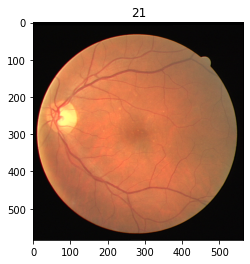

In [6]:
plt.imshow(train_images['21'])
plt.title('21')

(584, 565, 3)


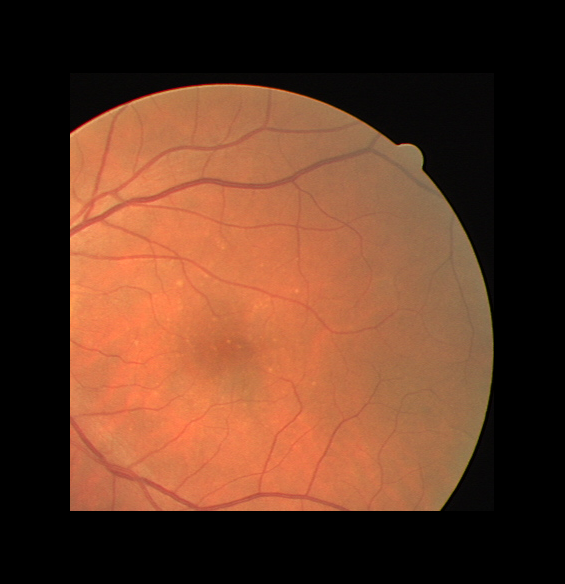

In [7]:
size = (438, 424)
i, j, h, w = RandomCrop.get_params(
            PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'),
             output_size=size)
TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)
up_down_pad = 584 - size[0]
left_right_pad = 565 - size[1]
top = up_down_pad//2
bottom = top + up_down_pad % 2
left = left_right_pad//2
right = left + left_right_pad % 2
cropped = TF.crop(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), i, j, h, w)
print(np.asarray(TF.pad(cropped, (left, top, right, bottom))).shape)
TF.pad(cropped, (left, top, right, bottom))

In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

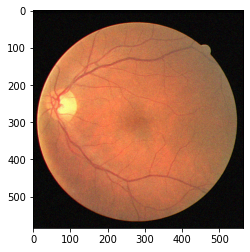

In [9]:
transform=Compose([
    ToTensor(),
    AddGaussianNoise(0, 0.05)
])

examp = transform(train_images['21'])
plt.imshow(examp.permute(1, 2, 0) , alpha=1)

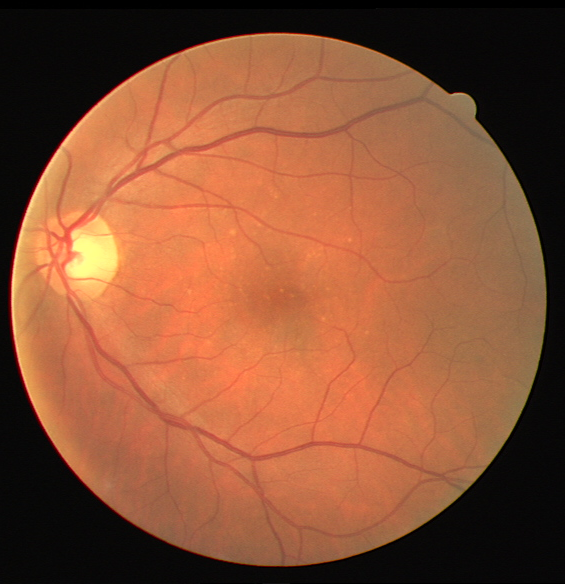

In [10]:
PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB')

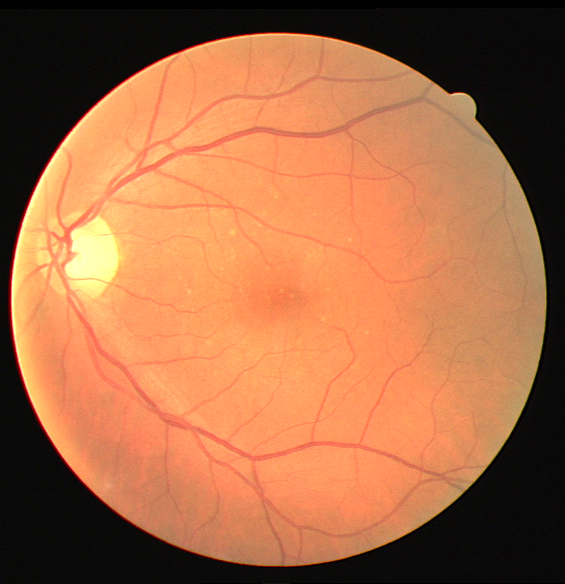

In [11]:
TF.adjust_brightness(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(0.5, 1.5))

In [12]:
#Procesado de los labels

In [13]:
path_labels = "../Data/dataset_DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

Text(0.5, 1.0, '21')

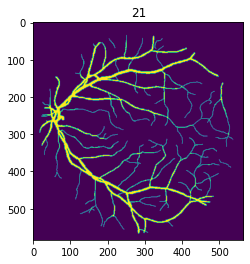

In [14]:
plt.imshow(labels['21'])
plt.title('21')

In [15]:
zeros = []
ones = []
for i in labels.keys():
    aux = labels[i]
    zeros.append(np.sum(aux==0).sum())
    ones.append(np.sum(aux==255).sum())

print(f"Avg_ratio: {np.mean(zeros)/np.mean(ones)}")

Avg_ratio: 10.646914517168044


Text(0.5, 1.0, '21')

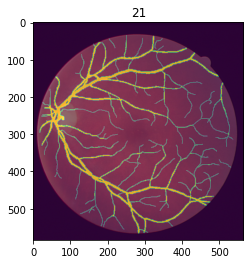

In [16]:
plt.imshow(labels['21'], alpha=1)
plt.imshow(train_images['21'], alpha=0.4)
plt.title('21')

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

TRAIN_IMG_DIR = "../Data/dataset_DRIVE/training/images"
TRAIN_MASK_DIR = "../Data/dataset_DRIVE/training/1st_manual"
VAL_IMG_DIR = "../Data/dataset_DRIVE/validation/images"
VAL_MASK_DIR = "../Data/dataset_DRIVE/validation/1st_manual"
RESIZE = None
BATCH_SIZE = 2
ROTATION = [-90, 90]
HFLIP_PROB = 0.5
BRIGHTNESS = [0.5, 1.5]
CONTRAST = [0.5, 1.5]
GAMMA = [0.5, 1.5]
CROP_SIZE = (438, 424)  #3/4 
P_CROP = 0.2
NOISE = (0, 0.05)  # (Mean,std)
NUM_WORKERS = 0
PIN_MEMORY = True

In [18]:
train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        ROTATION,
        HFLIP_PROB,
        BRIGHTNESS,
        CONTRAST,
        GAMMA,
        CROP_SIZE,
        P_CROP,
        NOISE,
        NUM_WORKERS,
        PIN_MEMORY)

Feature batch shape: torch.Size([2, 3, 584, 565])
Labels batch shape: torch.Size([2, 584, 565])
The Train image numbers present in the batch are: ('36', '32')


Text(0.5, 1.0, '36')

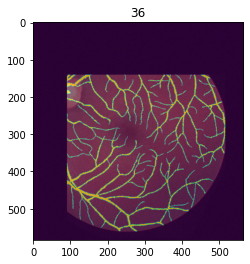

In [27]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

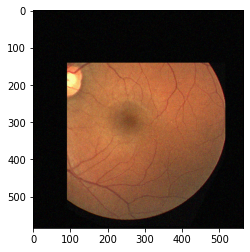

In [28]:
plt.imshow(img.permute(1, 2, 0) , alpha=1)

# Model 

In [14]:
checks1 = "./Checkpoints/2022_01_30_1/training_logs.pt"
checks2 = "./Checkpoints/2022_01_30_2/training_logs.pt"

weights1 = "./Checkpoints/2022_01_30_1/my_check.pth.tar"
weights2 = "./Checkpoints/2022_01_30_2/my_check.pth.tar"
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load(weights2, map_location=torch.device(DEVICE)),
    model)

 => Loading checkpoint 


In [6]:
a = torch.load(checks1)
b = torch.load(checks2)

In [30]:
a['best_dice']
b['best_dice']

0.7990298239364273

In [7]:
a['best_auc']

0.9840781571429302

In [ ]:
#Aquí se pintarían las gráficas

# Submission Grand Challenge

In [15]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test"

In [16]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import make_grid

In [10]:
test = ImageFolder(root=TEST_IMG_DIR, transform=transforms.ToTensor())

In [17]:
BATCH_SIZE = 4
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

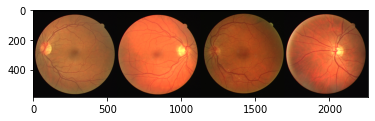

In [18]:
#First 4 test images
grid = make_grid(next(iter(test_loader))[0], nrow=4, padding=0, scale_each=True)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [19]:
# Predictions
folder = "../Data/dataset_DRIVE/submit/2022_01_30_2"
model.eval()
number = list(range(1,5,1))
for x in test_loader:
    x = x[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        for a,b in zip(preds,number):
            torchvision.utils.save_image(
            a, f"{folder}/{b}.png")
    number = [x + BATCH_SIZE for x in number]
